# EDA (Exploratory Data Analysis)

## Start SparkSession

In [47]:
# Import packages
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window
from pyspark.sql.dataframe import  DataFrame
import functools
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# Start Spark session
spark = SparkSession.builder.appName("EDA").getOrCreate()
print(f"Spark version: {spark.version}")

25/01/13 20:40:05 INFO SparkEnv: Registering MapOutputTracker
25/01/13 20:40:05 INFO SparkEnv: Registering BlockManagerMaster
25/01/13 20:40:05 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/01/13 20:40:05 INFO SparkEnv: Registering OutputCommitCoordinator


Spark version: 3.5.1


## Load data

In [60]:
df = spark.read.parquet("/TFM/data/bronze/velocidades_bitcarrier.parquet")

## Data exploration

In [5]:
# How much rows and columns we have
total_rows = df.count()
columns = df.columns
print(f"Total rows: {total_rows:,}".replace(",", "."))
print(f"Total columns: {len(columns)}")

Total rows: 71.719.687
Total columns: 24


In [6]:
# Show first rows
df.limit(10).show()

+--------+---+-------------------+-------------------+----+----+--------+----+------------+-----------+----------+---------+---------+----------+-------------+------+--------+----------+-------------+---------------+-------------------+-----------------+--------------+---------------+
|OBJECTID|TID|             INICIO|                FIN| AÑO|HORA|DISTANCE|TYPE|VEL_PROMEDIO|CUARTO_HORA|DIA_SEMANA|      MES|NAME_FROM|   NAME_TO|VEL_PONDERADA|CODIGO|COEF_BRT|COEF_MIXTO|VEL_MEDIA_BRT|VEL_MEDIA_MIXTO|VEL_MEDIA_PONDERADA|    Shape__Length|         LLAVE|NUMDISPOSITIVOS|
+--------+---+-------------------+-------------------+----+----+--------+----+------------+-----------+----------+---------+---------+----------+-------------+------+--------+----------+-------------+---------------+-------------------+-----------------+--------------+---------------+
|       1|  1|2021-04-01 00:00:00|2021-04-01 00:15:00|2021|   0|   17482|   0|   35.288937|   00:00:00|    Jueves|April    |      KR7|CL188;CL

In [7]:
# Print schema
df.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- TID: integer (nullable = true)
 |-- INICIO: timestamp (nullable = true)
 |-- FIN: timestamp (nullable = true)
 |-- AÑO: string (nullable = true)
 |-- HORA: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- TYPE: integer (nullable = true)
 |-- VEL_PROMEDIO: double (nullable = true)
 |-- CUARTO_HORA: string (nullable = true)
 |-- DIA_SEMANA: string (nullable = true)
 |-- MES: string (nullable = true)
 |-- NAME_FROM: string (nullable = true)
 |-- NAME_TO: string (nullable = true)
 |-- VEL_PONDERADA: double (nullable = true)
 |-- CODIGO: string (nullable = true)
 |-- COEF_BRT: double (nullable = true)
 |-- COEF_MIXTO: double (nullable = true)
 |-- VEL_MEDIA_BRT: double (nullable = true)
 |-- VEL_MEDIA_MIXTO: double (nullable = true)
 |-- VEL_MEDIA_PONDERADA: double (nullable = true)
 |-- Shape__Length: double (nullable = true)
 |-- LLAVE: string (nullable = true)
 |-- NUMDISPOSITIVOS: integer (nullable = true)



In [8]:
# Show null values percentage for each column
(
    df.select([ F.round(((F.count(F.when(F.col(col).isNull(), col))/total_rows)*100), 2).alias(col) for col in df.columns]).withColumn("UNPIVOT", F.lit(1))
    .unpivot("UNPIVOT", [*columns], "nombre_columna", "porcentaje_valores_nulos").drop(F.col("UNPIVOT")).sort(F.col("porcentaje_valores_nulos").desc())
).show(len(columns))

+-------------------+------------------------+
|     nombre_columna|porcentaje_valores_nulos|
+-------------------+------------------------+
|           COEF_BRT|                   94.63|
|         COEF_MIXTO|                   94.63|
|      VEL_MEDIA_BRT|                   94.63|
|    VEL_MEDIA_MIXTO|                   94.63|
|             CODIGO|                   75.85|
|              LLAVE|                   70.69|
|    NUMDISPOSITIVOS|                   61.25|
|VEL_MEDIA_PONDERADA|                   46.54|
|                AÑO|                    4.32|
|           DISTANCE|                    0.99|
|               TYPE|                    0.99|
|          NAME_FROM|                    0.99|
|            NAME_TO|                    0.99|
|      Shape__Length|                    0.99|
|           OBJECTID|                     0.0|
|                TID|                     0.0|
|             INICIO|                     0.0|
|                FIN|                     0.0|
|            

In [9]:
# Show example values for each column
col_join_key = "UNION_KEY"
dfs_example_values = [df.select(F.col(COLNAME)).where(F.col(COLNAME).isNotNull()).limit(1).withColumn(col_join_key, F.lit(1)) for COLNAME in df.columns]
dfs_example_values = functools.reduce(functools.partial(DataFrame.join, on=[col_join_key]), dfs_example_values)
dfs_example_values.toPandas().melt(id_vars=[col_join_key], value_vars=[*df.columns], var_name="column_name", value_name="example_value").drop(columns=[col_join_key])

,column_name,example_value
0,OBJECTID,611810
1,TID,1001059
2,INICIO,2021-04-01 00:00:00
3,FIN,2021-11-25 05:45:00
4,AÑO,2020
5,HORA,3
6,DISTANCE,906
7,TYPE,0
8,VEL_PROMEDIO,35.288937
9,CUARTO_HORA,00:00:00


In [10]:
# Statistics summary in numeric columns
df.select(F.col("DISTANCE"), F.col("VEL_PROMEDIO"), F.col("VEl_PONDERADA"), F.col("COEF_BRT"), F.col("COEF_MIXTO"), F.col("VEL_MEDIA_BRT"), F.col("VEL_MEDIA_MIXTO"), F.col("VEL_MEDIA_PONDERADA"), F.col("NUMDISPOSITIVOS"), F.col("Shape__Length")).summary().show()

25/01/13 20:11:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+--------------------+
|summary|         DISTANCE|      VEL_PROMEDIO|     VEl_PONDERADA|          COEF_BRT|         COEF_MIXTO|     VEL_MEDIA_BRT|   VEL_MEDIA_MIXTO|VEL_MEDIA_PONDERADA|  NUMDISPOSITIVOS|       Shape__Length|
+-------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+--------------------+
|  count|         71013194|          71719687|          71719687|           3853803|            3853803|           3853803|           3853803|           38343829|         27791036|            71013194|
|   mean|1324.246455567116| 28.76852456679515|27.418739188797222|0.5815645850286224| 0.4184354149714439|23.910654082975014|17.442293129716873|  26.04536983929322|7.245159446376882| 0.013355429

In [11]:
# Statistics summary of NUMDISPOSITIVOS column only for each year
(
    df.where(F.col("AÑO")==2020).select(F.col("NUMDISPOSITIVOS")).summary().withColumnRenamed("NUMDISPOSITIVOS", "NUMDISPOSITIVOS_2020")
    .join(df.where(F.col("AÑO")==2021).select(F.col("NUMDISPOSITIVOS")).summary().withColumnRenamed("NUMDISPOSITIVOS", "NUMDISPOSITIVOS_2021"), "summary")
    .join(df.where(F.col("AÑO")==2022).select(F.col("NUMDISPOSITIVOS")).summary().withColumnRenamed("NUMDISPOSITIVOS", "NUMDISPOSITIVOS_2022"), "summary")
).show()

+-------+--------------------+--------------------+--------------------+
|summary|NUMDISPOSITIVOS_2020|NUMDISPOSITIVOS_2021|NUMDISPOSITIVOS_2022|
+-------+--------------------+--------------------+--------------------+
|  count|                   0|             5603120|            19297269|
|   mean|                NULL|  6.3164531546709695|   7.492338268176704|
| stddev|                NULL|   5.758806082237867|  10.282916940940229|
|    min|                NULL|                   1|                   1|
|    25%|                NULL|                   3|                   3|
|    50%|                NULL|                   4|                   4|
|    75%|                NULL|                   7|                   8|
|    max|                NULL|                 118|                 780|
+-------+--------------------+--------------------+--------------------+



In [12]:
# Statistics summary of VEL_PROMEDIO column only for each year
(
    df.where(F.col("AÑO")==2020).select(F.col("VEL_PROMEDIO")).summary().withColumnRenamed("VEL_PROMEDIO", "VEL_PROMEDIO_2020")
    .join(df.where(F.col("AÑO")==2021).select(F.col("VEL_PROMEDIO")).summary().withColumnRenamed("VEL_PROMEDIO", "VEL_PROMEDIO_2021"), "summary")
    .join(df.where(F.col("AÑO")==2022).select(F.col("VEL_PROMEDIO")).summary().withColumnRenamed("VEL_PROMEDIO", "VEL_PROMEDIO_2022"), "summary")
).show()

+-------+------------------+------------------+------------------+
|summary| VEL_PROMEDIO_2020| VEL_PROMEDIO_2021| VEL_PROMEDIO_2022|
+-------+------------------+------------------+------------------+
|  count|          26018083|          23308459|          19297269|
|   mean|29.807563415146877|29.451147989747458|26.785079834673386|
| stddev|13.455069433395822|14.009847345045499|13.445746987748297|
|    min|           3.00322|          3.009375|              3.42|
|    25%|       19.55508567|            18.845|       16.75666667|
|    50%|        27.6326745|       27.08743867|       24.60666667|
|    75%|       37.88543267|        37.7504715|              34.8|
|    max|             99.99|           214.305|            212.91|
+-------+------------------+------------------+------------------+



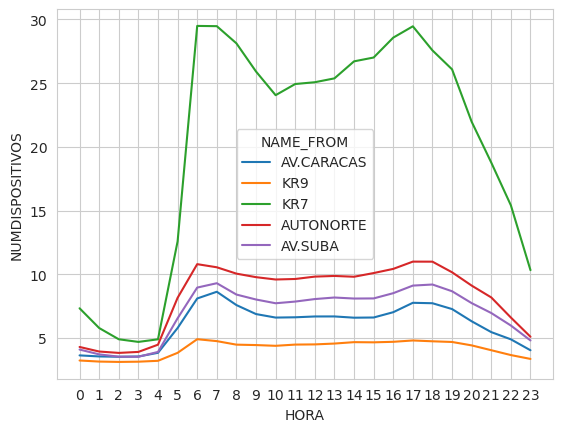

In [13]:
# Average of NUMDISPOSITIVOS for eac hour column for the principal streets
sns.set_style("whitegrid")
ax = sns.lineplot(data=df.where((F.col("NAME_FROM").isin("KR9", "KR7", "AUTONORTE", "AV.CARACAS", "AV.SUBA"))).groupby(F.col("NAME_FROM"), F.col("HORA")).agg(F.avg(F.col("NUMDISPOSITIVOS")).alias("NUMDISPOSITIVOS")).toPandas(), x="HORA", y="NUMDISPOSITIVOS", hue="NAME_FROM")
ax.set_xticks(range(24), labels=["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"])

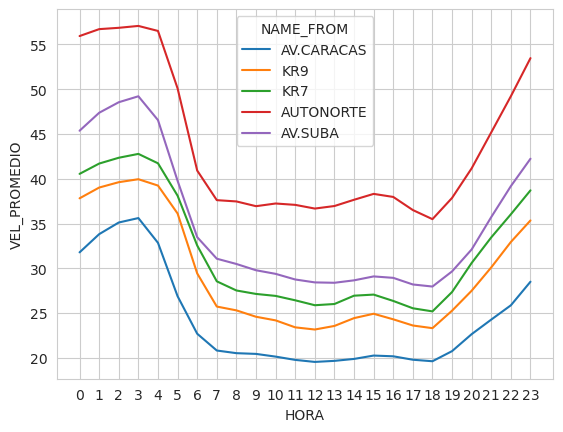

In [14]:
# Average of VEL_PROMEDIO for eac hour column for the principal streets
sns.set_style("whitegrid")
ax = sns.lineplot(data=df.where((F.col("NAME_FROM").isin("KR9", "KR7", "AUTONORTE", "AV.CARACAS", "AV.SUBA"))).groupby(F.col("NAME_FROM"), F.col("HORA")).agg(F.avg(F.col("VEL_PROMEDIO")).alias("VEL_PROMEDIO")).toPandas(), x="HORA", y="VEL_PROMEDIO", hue="NAME_FROM")
ax.set_xticks(range(24), labels=["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"])

In [15]:
# TYPE column by year without NULL in AÑO column
df.withColumn("AÑO", F.year(F.col("INICIO"))).groupby(F.col("AÑO"), F.col("TYPE")).count().sort(F.col("AÑO").asc(), F.col("TYPE").asc()).show()

+----+----+--------+
| AÑO|TYPE|   count|
+----+----+--------+
|2020|   0| 4625307|
|2020|   1|21544995|
|2021|NULL|  114703|
|2021|   0| 3086600|
|2021|   1|20221336|
|2022|NULL|  591790|
|2022|   1|21534956|
+----+----+--------+



In [16]:
# Is TID a unique values for each NAME_FROM and NAME_TO combination
print("Is TID unique for each NAME_FROM and NAME_TO combination?:", df.select(F.col("TID"), F.col("NAME_FROM"), F.col("NAME_TO")).distinct().groupby(F.col("TID")).count().where(F.col("count") > 1).count() == 0)

Is TID unique for each NAME_FROM and NAME_TO combination?: False


In [63]:
df = spark.read.parquet("/TFM/data/bronze/velocidades_bitcarrier.parquet")

# Create an unique id by path combination
df_route_id = df.select(F.col("NAME_FROM"), F.col("NAME_TO")).distinct().withColumn("ROUTE_ID", F.monotonically_increasing_id())

# Esto eliminará el 0.99% de los datos
df = df.join(F.broadcast(df_route_id), ["NAME_FROM", "NAME_TO"], how="inner")

# Repeat the test
print("Is ROUTE_ID unique for each NAME_FROM and NAME_TO combination?:", df.select(F.col("ROUTE_ID"), F.col("NAME_FROM"), F.col("NAME_TO")).distinct().groupby(F.col("ROUTE_ID")).count().where(F.col("count") > 1).count() == 0)

Is ROUTE_ID unique for each NAME_FROM and NAME_TO combination?: True


In [64]:
df.limit(10).show()

+---------+----------+--------+---+-------------------+-------------------+----+----+--------+----+------------+-----------+----------+---------+-------------+------+--------+----------+-------------+---------------+-------------------+-----------------+--------------+---------------+--------+
|NAME_FROM|   NAME_TO|OBJECTID|TID|             INICIO|                FIN| AÑO|HORA|DISTANCE|TYPE|VEL_PROMEDIO|CUARTO_HORA|DIA_SEMANA|      MES|VEL_PONDERADA|CODIGO|COEF_BRT|COEF_MIXTO|VEL_MEDIA_BRT|VEL_MEDIA_MIXTO|VEL_MEDIA_PONDERADA|    Shape__Length|         LLAVE|NUMDISPOSITIVOS|ROUTE_ID|
+---------+----------+--------+---+-------------------+-------------------+----+----+--------+----+------------+-----------+----------+---------+-------------+------+--------+----------+-------------+---------------+-------------------+-----------------+--------------+---------------+--------+
|      KR7|CL188;CL32|       1|  1|2021-04-01 00:00:00|2021-04-01 00:15:00|2021|   0|   17482|   0|   35.288937|   

In [17]:
# Create columns by NAME_TO column
df = df.withColumns(
    {
        "NAME_TO_1": F.replace(F.split_part(F.col("NAME_TO"), F.lit(";"), F.lit(1)), F.lit("CL"), F.lit("")).cast(T.IntegerType()),
        "NAME_TO_2": F.replace(F.split_part(F.col("NAME_TO"), F.lit(";"), F.lit(2)), F.lit("CL"), F.lit("")).cast(T.IntegerType()),
        "SENTIDO": F.when(F.col("NAME_TO_1") < F.col("NAME_TO_2"), F.lit("SUR-NORTE")).otherwise(F.lit("NORTE-SUR"))
    }
)

<Axes: xlabel='AÑO', ylabel='count'>

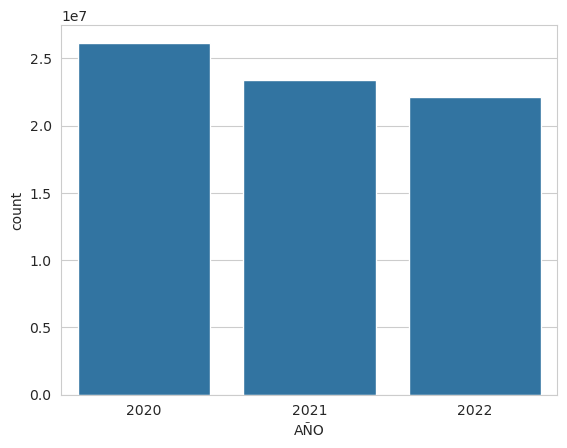

In [18]:
# How much data we have for each year?
sns.barplot(df.withColumn("AÑO", F.year(F.col("INICIO"))).groupby(F.col("AÑO")).count().toPandas(), x="AÑO", y="count")

In [38]:
# Hay variaciones en los tramos por años
(
    df.withColumn("AÑO", F.year(F.col("INICIO")))
    .withColumn("TRAMO_UNICO", F.concat(F.col("NAME_FROM"), F.lit(";"), F.col("NAME_TO")))
    .select(F.col("AÑO"), F.col("TRAMO_UNICO"))
    .distinct()
    .groupby(F.col("AÑO")).count()
    .sort(F.col("AÑO"))
).show()

+----+-----+
| AÑO|count|
+----+-----+
|2020|  845|
|2021| 1474|
|2022|  708|
+----+-----+



[[Text(0, 0.0, ''),
  Text(0, 500000.0, ''),
  Text(0, 1000000.0, ''),
  Text(0, 1500000.0, ''),
  Text(0, 2000000.0, ''),
  Text(0, 2500000.0, '')]]

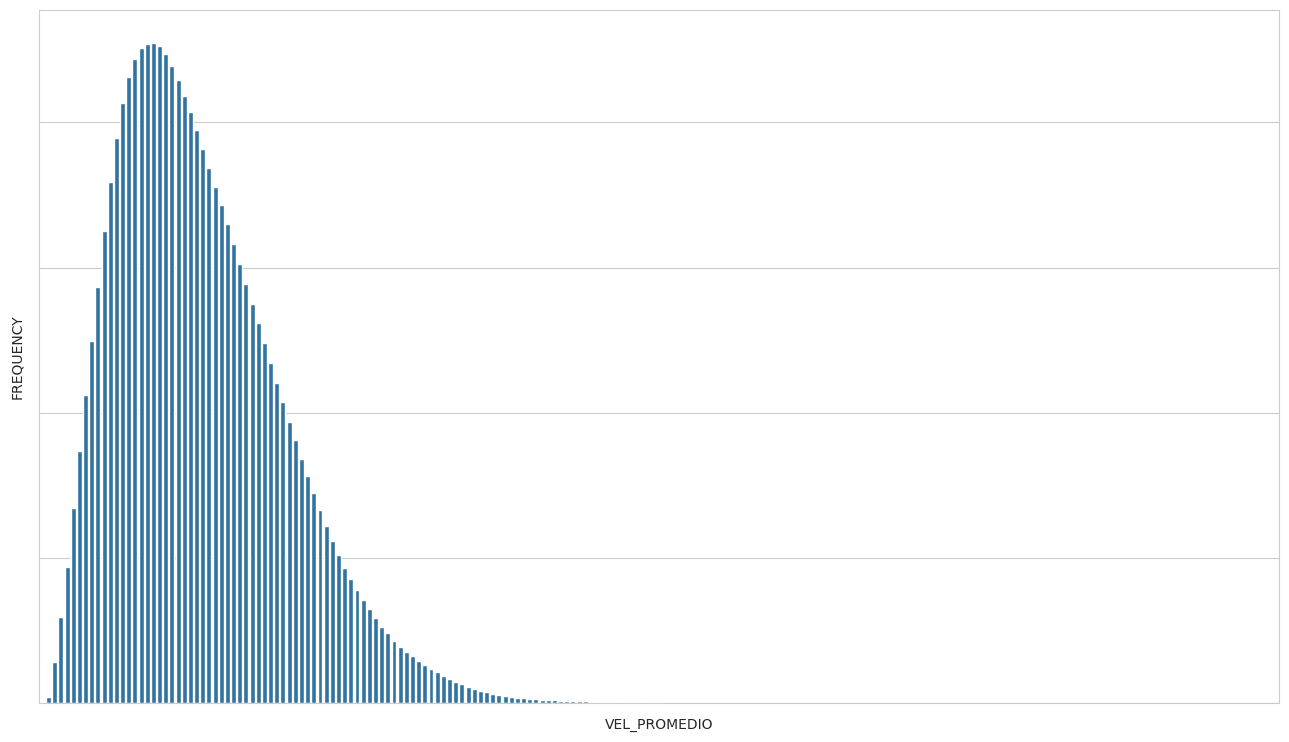

In [20]:
# Frequency diagram VEL_PROMEDIO
fig, ax = plt.subplots(figsize=(16, 9))
# setting the dimensions of the plot
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
g = sns.barplot(df.select(F.round(F.col("VEL_PROMEDIO"), 0).cast(T.IntegerType()).alias("VEL_PROMEDIO")).groupby(F.col("VEL_PROMEDIO")).agg(F.count(F.col("VEL_PROMEDIO")).alias("FREQUENCY")).toPandas(), x="VEL_PROMEDIO", y="FREQUENCY")
# Remove labels
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(yticklabels=[])

[[Text(0, 0.0, ''),
  Text(0, 2000000.0, ''),
  Text(0, 4000000.0, ''),
  Text(0, 6000000.0, ''),
  Text(0, 8000000.0, ''),
  Text(0, 10000000.0, ''),
  Text(0, 12000000.0, ''),
  Text(0, 14000000.0, '')]]

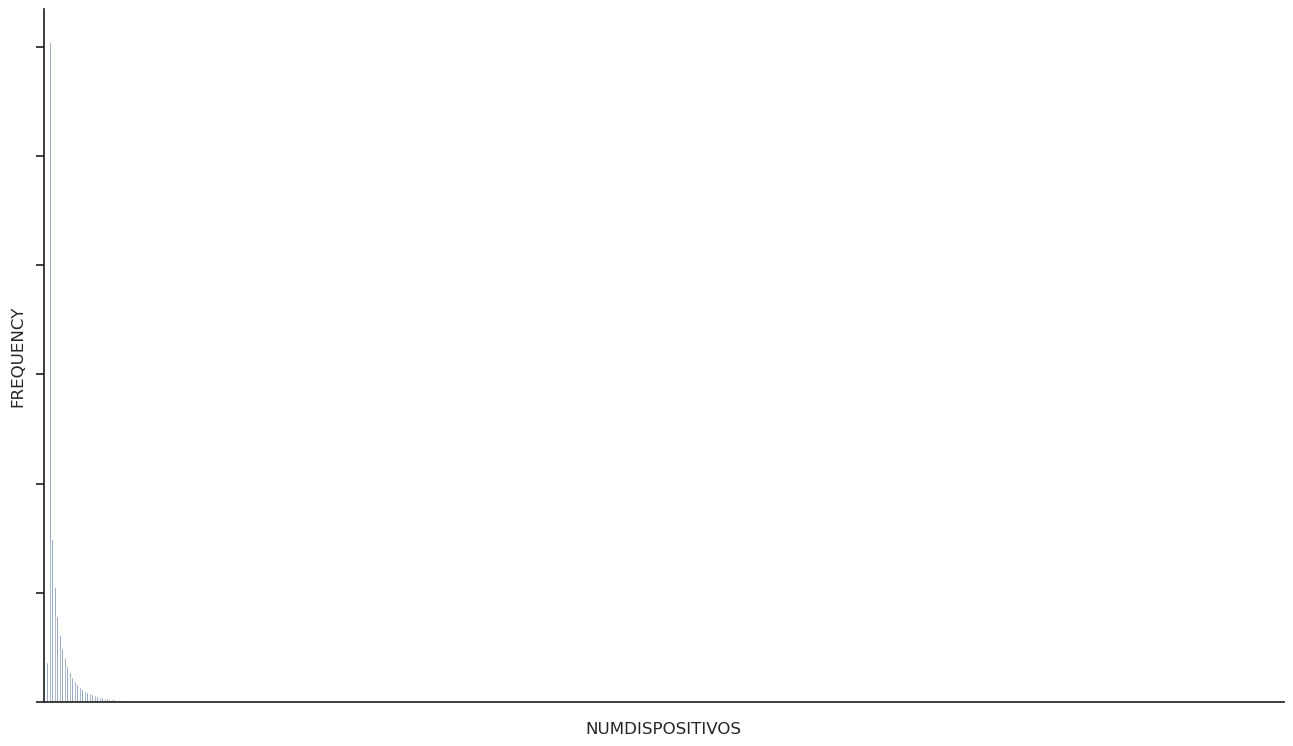

In [21]:
# Frequency distribution for NUMDISPOSITIVOS
fig, ax = plt.subplots(figsize=(16, 9))
# setting the dimensions of the plot
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
g = sns.barplot(df.select(F.round(F.col("NUMDISPOSITIVOS"), 0).cast(T.IntegerType()).alias("NUMDISPOSITIVOS")).groupby(F.col("NUMDISPOSITIVOS")).agg(F.count(F.col("NUMDISPOSITIVOS")).alias("FREQUENCY")).toPandas(), x="NUMDISPOSITIVOS", y="FREQUENCY")
# Remove labels
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(yticklabels=[])

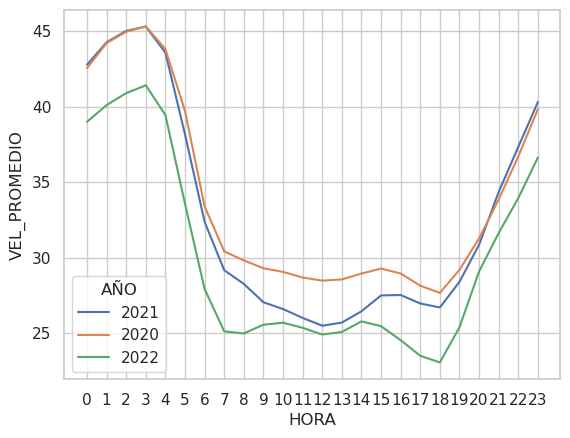

In [22]:
# VEL_PROMEDIO for each year by each hour
sns.set_style("whitegrid")
ax = sns.lineplot(data=df.where((F.col("NAME_FROM").isin("KR9", "KR7", "AUTONORTE", "AV.CARACAS", "AV.SUBA"))).groupby(F.col("AÑO"), F.col("HORA")).agg(F.avg(F.col("VEL_PROMEDIO")).alias("VEL_PROMEDIO")).toPandas(), x="HORA", y="VEL_PROMEDIO", hue="AÑO")
ax.set_xticks(range(24), labels=["0","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"])

In [23]:
# Distance of NAME_FROM
df.where(F.col("SENTIDO")=="NORTE-SUR").select(F.col("NAME_FROM"), F.col("DISTANCE")).distinct().groupby(F.col("NAME_FROM")).agg(F.sum(F.col("DISTANCE")).alias("TOTAL_DISTANCE")).sort(F.col("TOTAL_DISTANCE").desc()).limit(10).toPandas()

,NAME_FROM,TOTAL_DISTANCE
0,KR72,201623
1,KR86,102505
2,NQS,77597
3,AV.P.MAYO,48152
4,AV.CARACAS,45479
5,CL13,44551
6,KR68,44234
7,AUTONORTE,41495
8,CL80,38548
9,KR7,34484


In [24]:
# How much minutes is grouped the data? (Each 15 minutes)
(
    df.select(F.col("INICIO"), F.col("FIN"))
    .withColumn(
        "MinuteDifference", F.round((F.unix_timestamp(F.col("FIN")) - F.unix_timestamp(F.col("INICIO")))/60, 0)
    )
).select(F.col("MinuteDifference")).distinct().show()

+----------------+
|MinuteDifference|
+----------------+
|            15.0|
+----------------+



In [25]:
# Show days of week
df.select(F.col("DIA_SEMANA")).distinct().show()

+----------+
|DIA_SEMANA|
+----------+
|    Jueves|
|     Lunes|
|   Viernes|
| Miercoles|
|   Domingo|
|    Sabado|
|    Martes|
+----------+



In [26]:
# Show months
df.select(F.col("MES")).distinct().show()

+---------+
|      MES|
+---------+
|December |
|July     |
|March    |
|August   |
|June     |
|October  |
|May      |
|February |
|April    |
|September|
|January  |
|November |
+---------+



## Stop SparkSession

In [39]:
spark.stop()

## Next steps to create gold layer and traffic congestion analyst

- Columns to use: `INICIO`, `AÑO`, `HORA`, `DISTANCE`, `VEL_PROMEDIO`, `DIA_SEMANA`, `MES`, `NAME_FROM`, `NAME_TO`
- Create columns `NAME_TO_1`, `NAME_TO_2`, `SENTIDO`, and `MINUTO`.
- Fix null values in the column `AÑO`.
- Filter data for `AÑO == 2022` and `NAME_FROM =="KR7"` and `TYPE == 1`.
- Change to english language (some columns in the original dataset is in spanish and others in english).